In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import pandas as pd

In [ ]:

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta

    def forward(self, t, y):
        S, I, R= y
        neural_output = self.neural_part(torch.tensor([S, I], dtype=torch.float32).unsqueeze(0)).squeeze()
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = -abs(neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt])


In [ ]:

gamma = 0.07
beta = 2 * gamma
neural_ode_func = SimpleMLP()
model = CustomSIRSystem(neural_ode_func, gamma, beta)

y0 = torch.tensor([0.99, 0.01, 0.0], requires_grad=True)  
t = torch.linspace(0., 120., 120) 


In [ ]:

def get_data():
    gamma = 0.07
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R= y
        dS_dt = -beta * S * I 
        dI_dt = beta * S * I  - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()


def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 2] - true_y[:, 2]) ** 2)


def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 2] - true_y[:, 2])
    correct = (diff < threshold).float().mean()
    return correct.item()


In [ ]:

def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(5000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y

t, true_y, pred_y = train()


Iter 0, Loss: 0.8505774140357971, Accuracy: 1.67%
Iter 100, Loss: 0.5466877818107605, Accuracy: 1.67%
Iter 200, Loss: 0.34813055396080017, Accuracy: 1.67%
Iter 300, Loss: 0.2282603234052658, Accuracy: 1.67%
Iter 400, Loss: 0.15399180352687836, Accuracy: 1.67%
Iter 500, Loss: 0.08554425835609436, Accuracy: 8.33%
Iter 600, Loss: 0.04579956829547882, Accuracy: 5.83%
Iter 700, Loss: 0.033464036881923676, Accuracy: 5.00%
Iter 800, Loss: 0.028890468180179596, Accuracy: 5.00%
Iter 900, Loss: 0.026340927928686142, Accuracy: 5.00%
Iter 1000, Loss: 0.02422390505671501, Accuracy: 5.83%
Iter 1100, Loss: 0.02219279855489731, Accuracy: 5.00%
Iter 1200, Loss: 0.020205246284604073, Accuracy: 5.00%
Iter 1300, Loss: 0.018271280452609062, Accuracy: 5.83%
Iter 1400, Loss: 0.016421815380454063, Accuracy: 5.83%
Iter 1500, Loss: 0.014685398899018764, Accuracy: 5.83%
Iter 1600, Loss: 0.01307277288287878, Accuracy: 6.67%
Iter 1700, Loss: 0.011579935438930988, Accuracy: 7.50%
Iter 1800, Loss: 0.0102261984720826

In [ ]:
def forword_CF(x):
    
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
 
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
 
    result = x.clone().detach()
    

    result[1:] = x[1:] - x[:-1]
    
    return result

In [27]:
true_y[:,2] = forword_CF(true_y[:,2])
pred_y[:,2] = forword_CF(pred_y[:,2])

/tmp/ipykernel_2931398/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [28]:
data = {
    'Time': t.numpy(),
    'True_S': true_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': true_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': true_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],
}
df = pd.DataFrame(data)


In [29]:
df.to_excel('result/mlp/mlp2-16-1.xlsx', index=False)

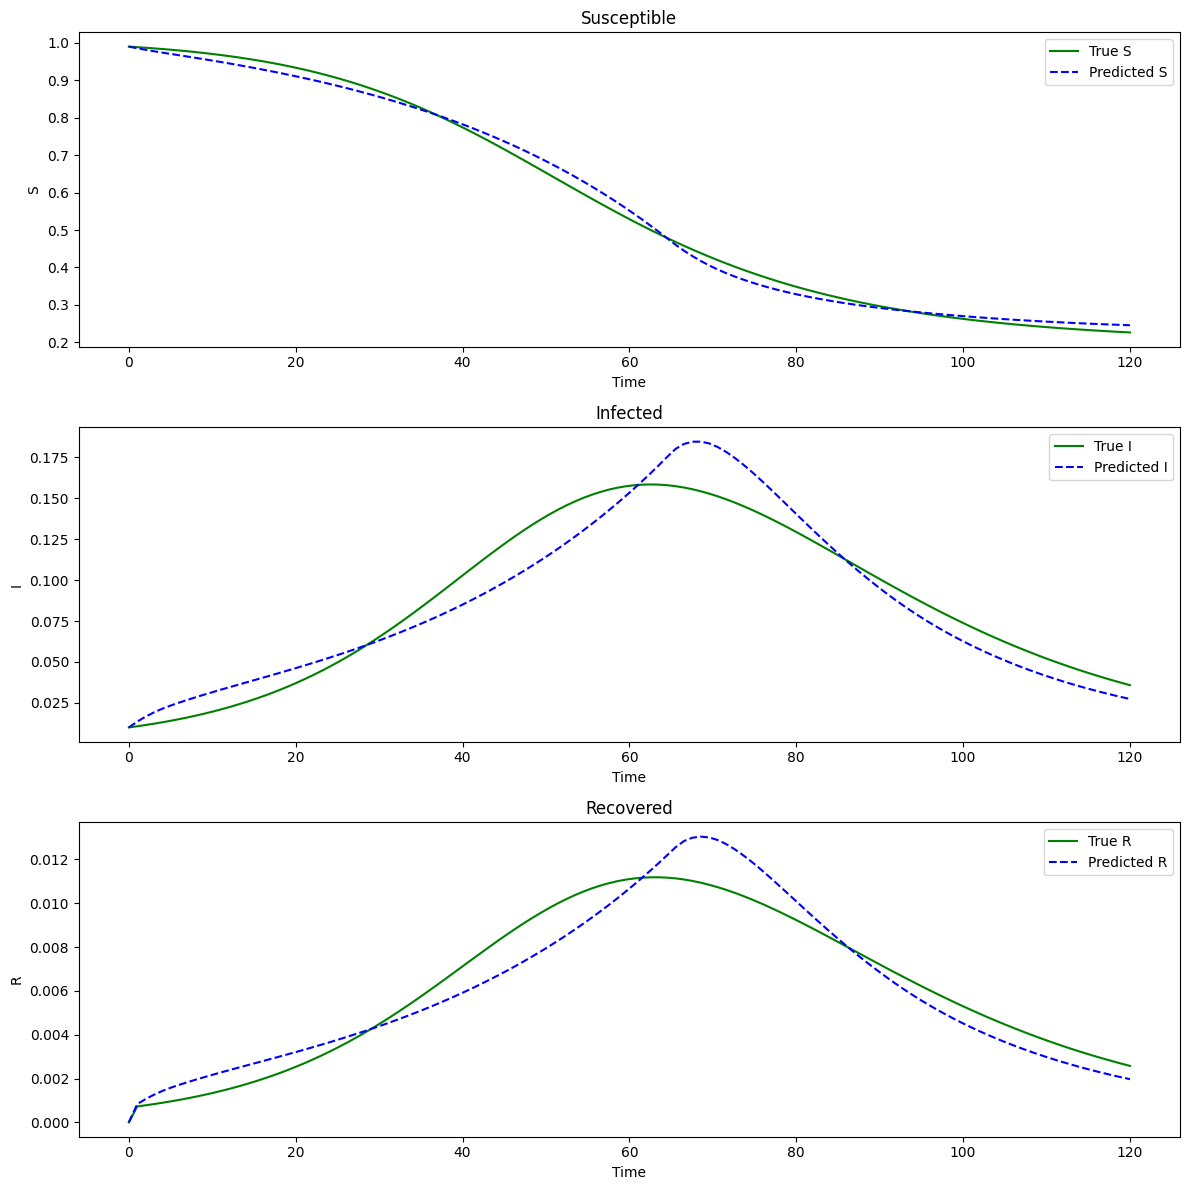

In [ ]:

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), true_y.numpy()[:, 0], 'g-', label='True S')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], 'b--', label='Predicted S')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), true_y.numpy()[:, 1], 'g-', label='True I')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], 'b--', label='Predicted I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), true_y.numpy()[:, 2], 'g-', label='True R')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], 'b--', label='Predicted R')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.savefig('picture/mlp/mlp2-16-1_SIR.png')
plt.show()
